In [1]:
import tensorflow as tf

In [2]:
# Adaptations for running Tensorflow on GeForce RTX 2080
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: GeForce RTX 2080, pci bus id: 0000:02:00.0, compute capability: 7.5



In [3]:
tf.test.is_gpu_available()

True

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Activation, Conv2D, Add

In [6]:
import PIL
from PIL import Image

In [7]:
def custom_ssim(y_actual, y_predicted):
    y_actual = (1+y_actual)/2
    y_predicted = (1+y_predicted)/2
    return 1 - tf.image.ssim(y_actual, y_predicted, max_val=1)

In [8]:
# Training parameters
num_train = 20 # number of images considered for training

In [9]:
# Loading data for training
# Images degraded by sigma = 2 and filter dimension = (7, 7) (gaussian blur)

blurred_train_aux = np.zeros((num_train, 256, 256, 1)) # array with degraded images for training 
original_train_aux = np.zeros((num_train, 256, 256, 1)) # array with non-degraded images for training 

for i in range (1, num_train):
    blurred_train_aux[i-1, :, :, 0] = np.load('dataset_gray/sigma2(7, 7)/arrays/degradada' + str(i) + '.npy')
    original_train_aux[i-1, :, :, 0] = np.load('dataset_gray/original/8/arrays/original' + str(i) + '.npy')

In [10]:
# Normalizing data
blurred_train_aux = blurred_train_aux/(blurred_train_aux.max())
original_train_aux = original_train_aux/(original_train_aux.max())

In [11]:
# Range of data: -1 to 1
blurred_train = 2*blurred_train_aux - 1
original_train = 2*original_train_aux - 1

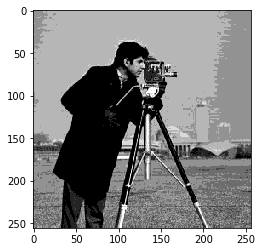

In [12]:
plt.imshow(original_train_aux[0, :, :, 0], cmap='gray')

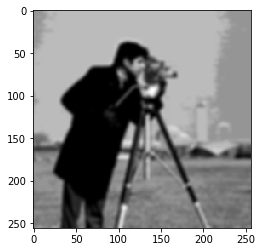

In [13]:
plt.imshow(blurred_train_aux[0, :, :, 0], cmap='gray')

In [14]:
# Converting data to tensor for SSIM comparison (SSIM function from Tensorflow library)
blurred_train_tf = tf.convert_to_tensor(blurred_train_aux)
original_train_tf = tf.convert_to_tensor(original_train_aux)

In [ ]:
# Loading data for testing
# Images degraded by sigma = 2 and filter dimension = (7, 7) (gaussian blur)

blurred_test_aux = np.zeros((2, 256, 256, 1)) # array with degraded images for testing
original_test_aux = np.zeros((2, 256, 256, 1)) # array with non-degraded images for testing

blurred_test_aux[:, :, :, 0] = np.load('dataset_gray/sigma2(7, 7)/arrays/degradada.npy')
original_test_aux[:, :, :, 0] = np.load('dataset_gray/original/8/arrays/original.npy')

In [16]:
# Normalizing data
blurred_test_aux = blurred_test_aux/(blurred_test_aux.max())
original_test_aux = original_test_aux/(original_test_aux.max())

In [17]:
# Range of data: -1 to 1
blurred_test = 2*blurred_test_aux - 1
original_test = 2*original_test_aux - 1

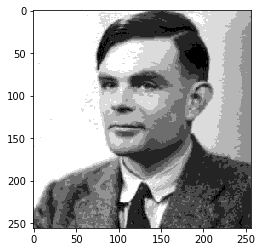

In [18]:
plt.imshow(original_test_aux[0, :, :, 0], cmap='gray')

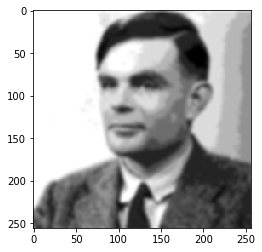

In [19]:
plt.imshow(blurred_test_aux[0, :, :, 0], cmap='gray')

In [20]:
# Converting data to tensor for SSIM comparison (SSIM function from Tensorflow library)
blurred_test_tf = tf.convert_to_tensor(blurred_test_aux)
original_test_tf = tf.convert_to_tensor(original_test_aux)

In [21]:
# Network model
def make_autoencoder(input_shape):
  
    X_input = Input(input_shape)

    X = Conv2D(1, (7, 7), padding="same")(X_input)
    X0 = Activation('tanh')(X)
    
    X = Conv2D(4, (7, 7), padding="same")(X0)
    X1 = Activation('tanh')(X)
    
    X = Conv2D(8, (7, 7), padding="same")(X1)
    X2 = Activation('tanh')(X)
    
    X = Conv2D(16, (7, 7), padding="same")(X2)
    X3 = Activation('tanh')(X)
    
    X = Conv2D(32, (7, 7), padding="same")(X3)
    X = Activation('tanh')(X)
 
    #latent space
 
    X = Conv2D(16, (7, 7), padding="same")(X)
    X = Activation('tanh')(X)
    X = Add()([X3, X])
    
    X = Conv2D(8, (7, 7), padding="same")(X)
    X = Activation('tanh')(X)
    X = Add()([X2, X])
    
    X = Conv2D(4, (7, 7), padding="same")(X)
    X = Activation('tanh')(X)
    X = Add()([X1, X])
    
    X = Conv2D(1, (7, 7), padding="same")(X)
    X = Activation('tanh')(X)
    X = Add()([X0, X])
    
    X = Conv2D(1, (7, 7), padding="same")(X)
    X = Activation('tanh')(X)
    

    model = Model(inputs=X_input, outputs=X)
    
    return model

In [22]:
mirrored_strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

Number of devices: 2


In [23]:
opt = Adam(lr=1e-4)

In [24]:
# Training with 2 GPUs
with mirrored_strategy.scope():
    model = make_autoencoder(blurred_train.shape[1:])
    model.compile(optimizer=opt, loss=custom_ssim)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 1)  50          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 1)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 4)  200         activation[0][0]                 
______________________________________________________________________________________________

In [ ]:
history = model.fit(x=blurred_train, y=original_train, epochs=20000, validation_data=[blurred_test, original_test])

dict_keys(['loss', 'val_loss'])


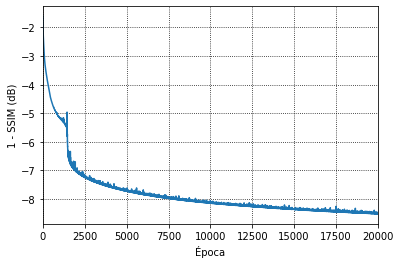

In [28]:
# Plotting loss
plt.plot(10*np.log10(history.history['loss']))
plt.xlim(0, 20000)
plt.grid(color='black', linestyle='dotted')
plt.ylabel('1 - SSIM (dB)')
plt.xlabel('Época')
plt.savefig('saved/residual_ssim/error.eps', format='eps')
plt.show()

In [29]:
# Restoration of image from testing dataset
test_prediction = (1+model.predict(blurred_test))/2
test_prediction_tf = tf.convert_to_tensor(test_prediction, np.float64)

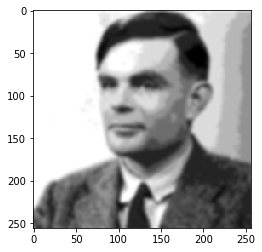

In [30]:
# Degraded image
plt.imshow(blurred_test[0, :, :, 0], cmap = 'gray')

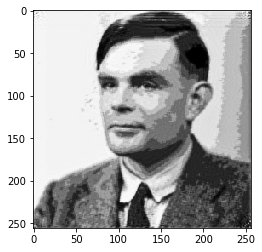

In [31]:
# Restored image
plt.imshow(test_prediction[0, :, :, 0], cmap = 'gray')
Image.fromarray((255*test_prediction[0, :, :, 0]).astype(np.uint8), mode='L').save('saved/residual_ssim/rest.eps')

In [32]:
# SSIM between original and degraded pictures
tf.image.ssim(original_test_tf, blurred_test_tf, max_val=1).numpy()

array([0.77463263, 0.77463263], dtype=float32)

In [33]:
# SSIM between original and restored pictures
tf.image.ssim(original_test_tf, test_prediction_tf, max_val=1).numpy()

array([0.89796674, 0.89796674], dtype=float32)

In [34]:
# Saving model
model.save('saved/residual_ssim/model.h5')